# Recurrent Neural Networks for Sentiment Analysis

**Deep Learning - University of Vermont**

---

In this coding session, you will learn the following:

1. **Build a basic RNN for sentiment classification** and understand why sequential processing matters for text.
2. **Compare three architectures (Vanilla RNN, GRU, LSTM)** on the same dataset, plot their learning curves, and explain which handles long reviews better and why.
3. **Build two sentiment classifiers and compare them**: one that averages word embeddings (ignores order), one that uses RNN (preserves order). Test on reviews like "not good" vs "good" to see why order matters.
4. **Apply pretrained word embeddings (GloVe)** to the same classification task. Compare accuracy against training embeddings from scratch and explain when transfer learning helps.
5. **Train a bidirectional RNN** on the same dataset and compare it to unidirectional RNN. Show examples where future context matters (like "This movie was not bad").

# Setup and Utilities

We will start by importing the necessary libraries and setting up our training environment.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from collections import Counter
import urllib.request
import zipfile
import os

# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Store results for comparison
results = {}

Using device: cuda


In [2]:
def train_model(model, train_loader, val_loader, epochs=5, lr=0.001, name="Model"):
    """
    Generic training loop for RNN models with validation.
    Returns training history for visualization.
    """
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()  # Binary classification
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print(f"\nTraining {name} for {epochs} epochs...")
    start_time = time.time()
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for texts, labels, lengths in train_loader:
            texts, labels = texts.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(texts, lengths).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).long()
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for texts, labels, lengths in val_loader:
                texts, labels = texts.to(device), labels.to(device).float()
                outputs = model(texts, lengths).squeeze()
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).long()
                total += labels.size(0)
                correct += (predicted == labels.long()).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        
        print(f"  Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
    
    duration = time.time() - start_time
    print(f"{name} - Final Val Accuracy: {history['val_acc'][-1]:.2f}%, Time: {duration:.2f}s")
    
    return history, duration

# 0. Data Preparation: IMDB Movie Reviews

We are using the **IMDB Dataset of 50K Movie Reviews**, a benchmark dataset for binary sentiment classification.

### Why IMDB Dataset?
- **Binary classification**: Positive (1) vs Negative (0) sentiment
- **50,000 reviews**: 25,000 for training, 25,000 for testing
- **Variable length**: Reviews range from a few words to several paragraphs
- **Real-world text**: Contains informal language, typos, and complex sentence structures

### Data Pipeline Strategy:
1. **Tokenization**: Split text into individual words (tokens)
2. **Vocabulary Building**: Create a mapping from words to integer indices
3. **Sequence Padding**: Pad/truncate all sequences to a fixed length for batching
4. **Embedding**: Convert word indices to dense vector representations

### Download the Dataset
Download the dataset from: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [3]:
# Load the IMDB dataset
# Make sure you have downloaded the dataset from Kaggle and placed it in ./data/

data_path = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

# Check if file exists
if not os.path.exists(data_path):
    print("Please download the IMDB dataset from:")
    print("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
    print(f"And place 'IMDB Dataset.csv' in {os.path.abspath('./data/')}")
else:
    df = pd.read_csv(data_path)
    print(f"Dataset loaded: {len(df)} reviews")
    print(f"\nSample review:")
    print(f"Review: {df['review'].iloc[0][:200]}...")
    print(f"Sentiment: {df['sentiment'].iloc[0]}")
    print(f"\nSentiment distribution:")
    print(df['sentiment'].value_counts())

Dataset loaded: 50000 reviews

Sample review:
Review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...
Sentiment: positive

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [4]:
# Text preprocessing functions

def clean_text(text):
    """
    Clean and preprocess text:
    - Remove HTML tags
    - Convert to lowercase
    - Remove special characters (keep only letters and spaces)
    """
    # Remove HTML tags like <br />
    text = re.sub(r'<[^>]+>', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Keep only letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def tokenize(text):
    """Simple whitespace tokenization."""
    return text.split()

# Apply preprocessing
df['clean_review'] = df['review'].apply(clean_text)
df['tokens'] = df['clean_review'].apply(tokenize)
df['label'] = (df['sentiment'] == 'positive').astype(int)

print("Sample processed review:")
print(f"Original: {df['review'].iloc[0][:100]}...")
print(f"Cleaned: {df['clean_review'].iloc[0][:100]}...")
print(f"Tokens: {df['tokens'].iloc[0][:10]}...")
print(f"Label: {df['label'].iloc[0]}")

Sample processed review:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Cleaned: one of the other reviewers has mentioned that after watching just oz episode youll be hooked they ar...
Tokens: ['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching']...
Label: 1


In [5]:
# Build vocabulary

class Vocabulary:
    """
    Vocabulary class to map words to indices and vice versa.
    
    Special tokens:
    - <PAD>: Padding token (index 0) - used to pad sequences to same length
    - <UNK>: Unknown token (index 1) - used for out-of-vocabulary words
    """
    def __init__(self, max_vocab_size=25000, min_freq=2):
        self.max_vocab_size = max_vocab_size
        self.min_freq = min_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freq = Counter()
        
    def build(self, token_lists):
        """Build vocabulary from a list of token lists."""
        # Count word frequencies
        for tokens in token_lists:
            self.word_freq.update(tokens)
        
        # Filter by minimum frequency and take top words
        filtered_words = [
            word for word, freq in self.word_freq.most_common()
            if freq >= self.min_freq
        ][:self.max_vocab_size - 2]  # -2 for PAD and UNK
        
        # Build mappings
        for idx, word in enumerate(filtered_words, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word
            
        print(f"Vocabulary built: {len(self.word2idx)} unique tokens")
        
    def encode(self, tokens):
        """Convert tokens to indices."""
        return [self.word2idx.get(token, 1) for token in tokens]  # 1 is <UNK>
    
    def decode(self, indices):
        """Convert indices back to tokens."""
        return [self.idx2word.get(idx, '<UNK>') for idx in indices]
    
    def __len__(self):
        return len(self.word2idx)

# Build vocabulary from training data
vocab = Vocabulary(max_vocab_size=25000, min_freq=2)
vocab.build(df['tokens'].tolist())

print(f"\nMost common words: {vocab.word_freq.most_common(10)}")

Vocabulary built: 25000 unique tokens

Most common words: [('the', 664024), ('and', 320753), ('a', 320610), ('of', 288490), ('to', 266937), ('is', 210520), ('in', 185078), ('it', 154929), ('i', 152153), ('this', 149912)]


In [6]:
# Create PyTorch Dataset

class IMDBDataset(Dataset):
    """
    PyTorch Dataset for IMDB reviews.
    
    Args:
        reviews: List of token lists
        labels: List of labels (0 or 1)
        vocab: Vocabulary object
        max_length: Maximum sequence length (truncate longer sequences)
    """
    def __init__(self, reviews, labels, vocab, max_length=256):
        self.reviews = reviews
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        tokens = self.reviews[idx][:self.max_length]  # Truncate if needed
        indices = self.vocab.encode(tokens)
        length = len(indices)
        return torch.tensor(indices), torch.tensor(self.labels[idx]), length

def collate_fn(batch):
    """
    Custom collate function to handle variable-length sequences.
    Pads sequences to the maximum length in the batch.
    """
    texts, labels, lengths = zip(*batch)
    
    # Pad sequences
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    lengths = torch.tensor(lengths)
    
    return texts_padded, labels, lengths

# Split data into train and validation sets
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Create datasets
train_dataset = IMDBDataset(
    train_df['tokens'].tolist(),
    train_df['label'].tolist(),
    vocab,
    max_length=256
)

val_dataset = IMDBDataset(
    val_df['tokens'].tolist(),
    val_df['label'].tolist(),
    vocab,
    max_length=256
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Test a batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"  Texts: {sample_batch[0].shape}")
print(f"  Labels: {sample_batch[1].shape}")
print(f"  Lengths: {sample_batch[2].shape}")

Training samples: 40000
Validation samples: 10000

Sample batch shapes:
  Texts: torch.Size([64, 256])
  Labels: torch.Size([64])
  Lengths: torch.Size([64])


# 0.1 Theoretical Foundation: Why Sequential Processing Matters for Text

## The Problem with Traditional Neural Networks

Consider the sentences:
- "The movie was **not good**"
- "The movie was **good**"

If we simply average the word vectors (Bag-of-Words approach), both sentences would have similar representations because they contain mostly the same words. The word "not" would be just another word in the average.

**Traditional feedforward networks treat text as a "bag of words"** - they ignore the sequential nature of language.

## The Key Insight: Order Matters!

Language has **temporal dependencies**:
- "not good" ≠ "good not"
- "I didn't hate the movie" is positive despite containing "hate"
- Context from earlier words affects interpretation of later words

## Recurrent Neural Networks: Processing Sequences

RNNs process text **one word at a time**, maintaining a **hidden state** that carries information from previous words.

### The RNN Equation

At each time step $t$:

$$h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$$

Where:
- $x_t$ is the input (word embedding) at time $t$
- $h_{t-1}$ is the previous hidden state
- $W_{hh}$ is the hidden-to-hidden weight matrix (recurrent weights)
- $W_{xh}$ is the input-to-hidden weight matrix
- $\tanh$ squashes values to [-1, 1]

### Why This Works for Sentiment

When the RNN reads "The movie was not good":

| Step | Word | Hidden State Contains |
|------|------|----------------------|
| 1 | "The" | Basic context |
| 2 | "movie" | "The movie" |
| 3 | "was" | "The movie was" |
| 4 | "not" | "The movie was not" |
| 5 | "good" | **"The movie was not good"** - knows "good" is negated! |

The final hidden state $h_5$ encodes the entire sequence context.

---

# 1. Basic RNN for Sentiment Classification

## Historical Context

Recurrent Neural Networks were introduced in the 1980s (Hopfield, 1982; Rumelhart et al., 1986), but they struggled with **vanishing gradients** when trained on long sequences. Despite this limitation, basic RNNs established the fundamental concept of **recurrence** - using feedback loops to process sequential data.

## Architecture

We will build a Vanilla RNN with the following architecture:

```
Input: Sequence of word indices [w1, w2, ..., wn]
    ↓
Embedding Layer: vocab_size → embed_dim (25000 → 100)
    ↓
RNN Layer: 2 stacked layers, hidden_dim=256, tanh activation
    ↓
Take final hidden state from last layer
    ↓
Dropout (0.5) → FC Layer (256 → 1) → Sentiment logit
```

### Strengths
- **Captures word order**: Unlike bag-of-words models
- **Variable-length input**: Can handle reviews of any length
- **Parameter sharing**: Same weights used at each time step (efficient)

### Limitations
- **Vanishing gradients**: Gradients shrink exponentially over long sequences
- **Short-term memory**: Struggles to remember information from many steps ago
- **Sequential processing**: Cannot be parallelized (slow training)

**Important Note**: We expect the Vanilla RNN to perform **poorly** (~50% accuracy, essentially random guessing) on this task due to the vanishing gradient problem. This demonstrates why LSTM and GRU were invented!

In [7]:
class VanillaRNN(nn.Module):
    """
    Vanilla RNN for Sentiment Classification.
    
    Architecture:
    1. Embedding layer: Converts word indices to dense vectors
    2. RNN layer: Processes sequence and maintains hidden state
    3. Fully connected layer: Maps final hidden state to output
    
    The RNN equation at each timestep:
        h_t = tanh(W_ih * x_t + b_ih + W_hh * h_{t-1} + b_hh)
    
    Args:
        vocab_size: Number of unique tokens in vocabulary
        embed_dim: Dimension of word embeddings
        hidden_dim: Dimension of RNN hidden state
        output_dim: Output dimension (1 for binary classification)
        num_layers: Number of stacked RNN layers
        dropout: Dropout probability for regularization
    """
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=256, output_dim=1, 
                 num_layers=1, dropout=0.5):
        super(VanillaRNN, self).__init__()
        
        # Embedding layer: vocab_size -> embed_dim
        # Each word index is mapped to a dense vector
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=0  # Index 0 is <PAD>, its embedding stays zero
        )
        
        # RNN layer
        # Input: (batch, seq_len, embed_dim)
        # Output: (batch, seq_len, hidden_dim), (num_layers, batch, hidden_dim)
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,  # Input shape: (batch, seq, feature)
            dropout=dropout if num_layers > 1 else 0,
            nonlinearity='tanh'  # tanh is the default and most common
        )
        
        # Fully connected layer: hidden_dim -> output_dim
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, lengths):
        """
        Forward pass.
        
        Args:
            text: Tensor of word indices (batch, seq_len)
            lengths: Actual lengths of sequences (before padding)
            
        Returns:
            output: Sentiment logits (batch, 1)
        """
        # Embed the text: (batch, seq_len) -> (batch, seq_len, embed_dim)
        embedded = self.dropout(self.embedding(text))
        
        # Process through RNN
        # output: (batch, seq_len, hidden_dim) - hidden state at each timestep
        # hidden: (num_layers, batch, hidden_dim) - final hidden state
        output, hidden = self.rnn(embedded)
        
        # Use the final hidden state from the last layer
        # hidden[-1] shape: (batch, hidden_dim)
        final_hidden = self.dropout(hidden[-1])
        
        # Project to output dimension
        return self.fc(final_hidden)


# Initialize the model
vanilla_rnn = VanillaRNN(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=256,
    output_dim=1,
    num_layers=2,
    dropout=0.5
)

# Count parameters
params_rnn = sum(p.numel() for p in vanilla_rnn.parameters())
print(f"Vanilla RNN Parameters: {params_rnn:,}")

# Print model architecture
print(f"\nModel Architecture:")
print(vanilla_rnn)

Vanilla RNN Parameters: 2,723,489

Model Architecture:
VanillaRNN(
  (embedding): Embedding(25000, 100, padding_idx=0)
  (rnn): RNN(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [8]:
# Train Vanilla RNN
history_rnn, time_rnn = train_model(
    vanilla_rnn, train_loader, val_loader, 
    epochs=5, lr=0.001, name="Vanilla RNN"
)

results['Vanilla RNN'] = {
    'train_acc': history_rnn['train_acc'][-1],
    'val_acc': history_rnn['val_acc'][-1],
    'params': params_rnn,
    'time': time_rnn,
    'history': history_rnn
}


Training Vanilla RNN for 5 epochs...
  Epoch [1/5] | Train Loss: 0.7020 | Train Acc: 49.90% | Val Loss: 0.6938 | Val Acc: 49.13%
  Epoch [2/5] | Train Loss: 0.6991 | Train Acc: 49.70% | Val Loss: 0.6982 | Val Acc: 49.07%
  Epoch [3/5] | Train Loss: 0.6992 | Train Acc: 50.00% | Val Loss: 0.6927 | Val Acc: 51.12%
  Epoch [4/5] | Train Loss: 0.6996 | Train Acc: 49.78% | Val Loss: 0.7003 | Val Acc: 49.12%
  Epoch [5/5] | Train Loss: 0.6990 | Train Acc: 49.86% | Val Loss: 0.6933 | Val Acc: 50.56%
Vanilla RNN - Final Val Accuracy: 50.56%, Time: 69.36s


### Discussion: Vanilla RNN Results

The Vanilla RNN achieved only **~50.56% accuracy** - essentially random guessing for a binary classification task! This is **exactly what we expected** and demonstrates the critical limitations of basic RNNs.

**Why did the Vanilla RNN fail?**

1. **Vanishing Gradients**: With sequences up to 256 tokens, gradients must flow through hundreds of matrix multiplications during backpropagation. Each multiplication shrinks the gradient, causing it to vanish before reaching early layers.

2. **Unable to Learn**: The model's loss stayed around 0.69 (close to $-\ln(0.5) \approx 0.693$, the loss for random 50/50 predictions), indicating it never learned meaningful patterns.

3. **No Long-Range Dependencies**: Sentiment often depends on words far apart (e.g., "not" and "good" in "The movie was not particularly good"). Vanilla RNNs cannot capture these relationships.

**Key Metrics:**
- **Validation Accuracy**: 50.56% (random guessing = 50%)
- **Training Time**: ~71 seconds (fast, but useless if it can't learn!)
- **Parameters**: 2.72M

This result motivates our next section: **LSTM and GRU**, which were specifically designed to solve the vanishing gradient problem.

---

# 0.2 Theoretical Foundation: The Vanishing Gradient Problem

## The Problem

When training RNNs with backpropagation through time (BPTT), gradients must flow backward through many timesteps. At each step, gradients are multiplied by the weight matrix $W_{hh}$.

If we have a sequence of length $T$, the gradient at the first timestep involves:

$$\frac{\partial L}{\partial h_1} \propto \prod_{t=1}^{T-1} W_{hh} \cdot \tanh'(h_t)$$

**Problem**: If eigenvalues of $W_{hh}$ are < 1, gradients **shrink exponentially**. If > 1, they **explode**.

![Vanishing Gradient](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*yQzlE7JseW32VVU-xlOUvg.png)

*Gradient flow in RNNs. Darker colors indicate larger gradients. Notice how gradients fade to near-zero for early timesteps. Source: [The Vanishing Gradient Problem](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484)*

### Real-World Impact

Consider the review: "Despite the **terrible** acting, confusing plot, and boring dialogue, I must say the **ending** was surprisingly **good**."

- The word "terrible" is ~15 words before "good"
- By the time we process "good", the gradient signal from "terrible" has vanished
- The network can't learn that "terrible" should influence the final prediction

## The Solutions: LSTM and GRU

Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) solve this by introducing **gates** that control information flow:

1. **Forget Gate**: Decide what to discard from the cell state
2. **Input Gate**: Decide what new information to store
3. **Output Gate**: Decide what to output from the cell state

These gates create "shortcuts" for gradients to flow through, similar to ResNet's skip connections!

---

# 2. Comparing Architectures: Vanilla RNN vs GRU vs LSTM

Now we'll implement and compare three architectures on the same dataset to understand their trade-offs.

## 2.1 LSTM (Long Short-Term Memory)

### Historical Context
Introduced by Hochreiter & Schmidhuber in 1997, LSTM was specifically designed to solve the vanishing gradient problem.

### Architecture

![LSTM Cell](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*goJVQs-p9kgLODFNyhl9zA.gif)

*The LSTM cell with its three gates: forget (f), input (i), and output (o). The cell state C acts as a "conveyor belt" carrying information across timesteps. Source: [Understanding LSTM Networks - colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)*

### Our LSTM Implementation

```
Input: Sequence of word indices [w1, w2, ..., wn]
    ↓
Embedding Layer: vocab_size → embed_dim (25000 → 100)
    ↓
LSTM Layer: 2 stacked layers, hidden_dim=256
    - Maintains hidden state (h) AND cell state (c)
    - 3 gates: forget, input, output
    ↓
Take final hidden state from last layer
    ↓
Dropout (0.5) → FC Layer (256 → 1) → Sentiment logit
```


### Why This Solves Vanishing Gradients

The cell state $C_t$ acts as a **memory highway**:
- Gradients can flow through $C_t$ with only element-wise multiplication (no matrix multiplication!)
- When forget gate $f_t \approx 1$, information passes unchanged
- This is conceptually similar to ResNet's skip connections!

In [9]:
class LSTMClassifier(nn.Module):
    """
    LSTM for Sentiment Classification.
    
    Architecture matches the diagram above:
    - Embedding: 25000 vocab → 100 dim vectors
    - LSTM: 2 layers, 256 hidden units, with dropout between layers
    - FC: 256 → 1 (binary classification logit)
    
    Key difference from Vanilla RNN:
    - Maintains BOTH hidden state (h) and cell state (c)
    - Cell state acts as "memory highway" for gradient flow
    - Three gates control information: forget, input, output
    """
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=256, output_dim=1,
                 num_layers=2, dropout=0.5, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        
        # Store config for forward pass
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # ============================================
        # LAYER 1: Embedding Layer
        # ============================================
        # Converts word indices to dense vectors
        # Shape: (batch, seq_len) → (batch, seq_len, embed_dim)
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,  # Size of vocabulary (25000)
            embedding_dim=embed_dim,     # Dimension of embeddings (100)
            padding_idx=0                # Index 0 (<PAD>) always maps to zeros
        )
        
        # ============================================
        # LAYER 2: LSTM Layer
        # ============================================
        # Processes sequence and maintains hidden + cell states
        # Input shape: (batch, seq_len, embed_dim)
        # Output shape: (batch, seq_len, hidden_dim * num_directions)
        # Hidden shape: (num_layers * num_directions, batch, hidden_dim)
        self.lstm = nn.LSTM(
            input_size=embed_dim,        # Input features per timestep (100)
            hidden_size=hidden_dim,      # Hidden state size (256)
            num_layers=num_layers,       # Stacked LSTM layers (2)
            batch_first=True,            # Input: (batch, seq, features)
            dropout=dropout if num_layers > 1 else 0,  # Dropout between layers
            bidirectional=bidirectional  # Process both directions?
        )
        
        # ============================================
        # LAYER 3: Output Layer
        # ============================================
        # Maps final hidden state to sentiment logit
        # If bidirectional, we concatenate forward and backward hidden states
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)
        
        # Dropout for regularization (applied to embeddings and final hidden)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, lengths):
        """
        Forward pass through the network.
        
        Args:
            text: (batch, seq_len) - Padded word indices
            lengths: (batch,) - Actual lengths before padding (unused here but kept for API consistency)
            
        Returns:
            (batch, 1) - Sentiment logits (use sigmoid for probabilities)
        """
        # Step 1: Embed words
        # (batch, seq_len) → (batch, seq_len, 100)
        embedded = self.dropout(self.embedding(text))
        
        # Step 2: Process through LSTM
        # output: (batch, seq_len, hidden_dim * num_directions) - all hidden states
        # hidden: tuple of (h_n, c_n)
        #   h_n: (num_layers * num_directions, batch, hidden_dim) - final hidden state
        #   c_n: (num_layers * num_directions, batch, hidden_dim) - final cell state
        output, (hidden, cell) = self.lstm(embedded)
        
        # Step 3: Extract final hidden state for classification
        if self.bidirectional:
            # Concatenate last forward hidden state and last backward hidden state
            # hidden[-2]: last layer, forward direction
            # hidden[-1]: last layer, backward direction
            final_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            # Just use the last layer's hidden state
            final_hidden = hidden[-1]  # (batch, hidden_dim)
        
        # Step 4: Apply dropout and classify
        final_hidden = self.dropout(final_hidden)
        return self.fc(final_hidden)  # (batch, 1)


# ============================================
# Initialize LSTM Model
# ============================================
lstm_model = LSTMClassifier(
    vocab_size=len(vocab),   # 25000 words
    embed_dim=100,           # 100-dimensional embeddings
    hidden_dim=256,          # 256 hidden units
    output_dim=1,            # Binary classification
    num_layers=2,            # 2 stacked LSTM layers
    dropout=0.5              # 50% dropout
)

# Count parameters
params_lstm = sum(p.numel() for p in lstm_model.parameters())
print(f"LSTM Parameters: {params_lstm:,}")
print(f"Parameter increase over Vanilla RNN: {params_lstm / params_rnn:.2f}x")
print(f"\nParameter breakdown:")
print(f"  Embedding: {25000 * 100:,} = 2.5M")
print(f"  LSTM: {params_lstm - 25000*100 - 256 - 1:,} (4 gates × input/hidden weights × 2 layers)")
print(f"  FC: {256 * 1 + 1:,}")

LSTM Parameters: 3,393,185
Parameter increase over Vanilla RNN: 1.25x

Parameter breakdown:
  Embedding: 2,500,000 = 2.5M
  LSTM: 892,928 (4 gates × input/hidden weights × 2 layers)
  FC: 257


## 2.2 GRU (Gated Recurrent Unit)

### Historical Context
Introduced by Cho et al. in 2014, GRU is a simplified version of LSTM that combines the forget and input gates into a single "update gate."

### Architecture

![GRU Cell](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*jhi5uOm9PvZfmxvfaCektw.png)

*The GRU cell with reset gate (r) and update gate (z). GRU combines the cell state and hidden state into a single state, making it simpler than LSTM. Source: [Understanding GRU Networks - Towards Data Science](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be)*

### Our GRU Implementation

```
Input: Sequence of word indices [w1, w2, ..., wn]
    ↓
Embedding Layer: vocab_size → embed_dim (25000 → 100)
    ↓
GRU Layer: 2 stacked layers, hidden_dim=256
    - Only hidden state (no separate cell state)
    - 2 gates: reset, update (simpler than LSTM's 3)
    ↓
Take final hidden state from last layer
    ↓
Dropout (0.5) → FC Layer (256 → 1) → Sentiment logit
```

### GRU Equations

At each timestep $t$:

**Reset Gate** (how much past to forget when computing candidate):
$$r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$$

**Update Gate** (how much past to keep vs new info):
$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$$

**Candidate Hidden State** (new candidate using reset gate):
$$\tilde{h}_t = \tanh(W \cdot [r_t \odot h_{t-1}, x_t])$$

**Final Hidden State** (interpolate between old and new):
$$h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$$

### GRU vs LSTM Comparison

| Aspect | LSTM | GRU |
|--------|------|-----|
| Gates | 3 (forget, input, output) | 2 (reset, update) |
| States | 2 (hidden h + cell C) | 1 (hidden h only) |
| Parameters | ~4 × hidden_dim² per layer | ~3 × hidden_dim² per layer |
| Convergence | Slower, more stable | Faster, sometimes less stable |
| Best for | Very long sequences, complex patterns | Shorter sequences, limited training time |

In [10]:
class GRUClassifier(nn.Module):
    """
    GRU for Sentiment Classification.
    
    Architecture matches the diagram above:
    - Embedding: 25000 vocab → 100 dim vectors
    - GRU: 2 layers, 256 hidden units, with dropout between layers
    - FC: 256 → 1 (binary classification logit)
    
    Key differences from LSTM:
    - Only 2 gates instead of 3 (reset + update vs forget + input + output)
    - No separate cell state (just hidden state)
    - Fewer parameters, often faster convergence
    """
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=256, output_dim=1,
                 num_layers=2, dropout=0.5, bidirectional=False):
        super(GRUClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # ============================================
        # LAYER 1: Embedding Layer  
        # ============================================
        # Same as LSTM - converts word indices to dense vectors
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=0
        )
        
        # ============================================
        # LAYER 2: GRU Layer
        # ============================================
        # Simpler than LSTM - only returns hidden state (no cell state)
        # Uses reset gate (r) and update gate (z) instead of 3 gates
        # Input shape: (batch, seq_len, embed_dim)
        # Output shape: (batch, seq_len, hidden_dim * num_directions)
        # Hidden shape: (num_layers * num_directions, batch, hidden_dim)
        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # ============================================
        # LAYER 3: Output Layer
        # ============================================
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, lengths):
        """
        Forward pass - similar to LSTM but simpler.
        
        Key difference: GRU returns only hidden state, not (hidden, cell) tuple.
        """
        # Step 1: Embed words
        embedded = self.dropout(self.embedding(text))
        
        # Step 2: Process through GRU
        # Note: Unlike LSTM, GRU only returns hidden (no cell state!)
        # output: (batch, seq_len, hidden_dim * num_directions)
        # hidden: (num_layers * num_directions, batch, hidden_dim)
        output, hidden = self.gru(embedded)
        
        # Step 3: Extract final hidden state
        if self.bidirectional:
            final_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            final_hidden = hidden[-1]
        
        # Step 4: Classify
        final_hidden = self.dropout(final_hidden)
        return self.fc(final_hidden)


# ============================================
# Initialize GRU Model
# ============================================
gru_model = GRUClassifier(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=256,
    output_dim=1,
    num_layers=2,
    dropout=0.5
)

# Count and compare parameters
params_gru = sum(p.numel() for p in gru_model.parameters())
print(f"GRU Parameters: {params_gru:,}")
print(f"GRU has {params_lstm - params_gru:,} fewer parameters than LSTM")
print(f"GRU is {params_lstm / params_gru:.2f}x smaller than LSTM")
print(f"\nWhy fewer? GRU has 2 gates vs LSTM's 3 gates")
print(f"  LSTM: 4 weight matrices per layer (forget, input, cell, output)")
print(f"  GRU:  3 weight matrices per layer (reset, update, candidate)")

GRU Parameters: 3,169,953
GRU has 223,232 fewer parameters than LSTM
GRU is 1.07x smaller than LSTM

Why fewer? GRU has 2 gates vs LSTM's 3 gates
  LSTM: 4 weight matrices per layer (forget, input, cell, output)
  GRU:  3 weight matrices per layer (reset, update, candidate)


In [11]:
# Train LSTM
history_lstm, time_lstm = train_model(
    lstm_model, train_loader, val_loader,
    epochs=5, lr=0.001, name="LSTM"
)

results['LSTM'] = {
    'train_acc': history_lstm['train_acc'][-1],
    'val_acc': history_lstm['val_acc'][-1],
    'params': params_lstm,
    'time': time_lstm,
    'history': history_lstm
}


Training LSTM for 5 epochs...
  Epoch [1/5] | Train Loss: 0.6936 | Train Acc: 50.56% | Val Loss: 0.6923 | Val Acc: 51.52%
  Epoch [2/5] | Train Loss: 0.6934 | Train Acc: 51.51% | Val Loss: 0.6900 | Val Acc: 51.58%
  Epoch [3/5] | Train Loss: 0.6897 | Train Acc: 52.77% | Val Loss: 0.6876 | Val Acc: 53.11%
  Epoch [4/5] | Train Loss: 0.6893 | Train Acc: 52.65% | Val Loss: 0.6946 | Val Acc: 50.78%
  Epoch [5/5] | Train Loss: 0.6649 | Train Acc: 58.56% | Val Loss: 0.6480 | Val Acc: 62.89%
LSTM - Final Val Accuracy: 62.89%, Time: 190.31s


In [12]:
# Train GRU
history_gru, time_gru = train_model(
    gru_model, train_loader, val_loader,
    epochs=5, lr=0.001, name="GRU"
)

results['GRU'] = {
    'train_acc': history_gru['train_acc'][-1],
    'val_acc': history_gru['val_acc'][-1],
    'params': params_gru,
    'time': time_gru,
    'history': history_gru
}


Training GRU for 5 epochs...
  Epoch [1/5] | Train Loss: 0.6942 | Train Acc: 50.62% | Val Loss: 0.6911 | Val Acc: 51.67%
  Epoch [2/5] | Train Loss: 0.6969 | Train Acc: 51.31% | Val Loss: 0.6916 | Val Acc: 53.64%
  Epoch [3/5] | Train Loss: 0.6948 | Train Acc: 52.30% | Val Loss: 0.6679 | Val Acc: 58.43%
  Epoch [4/5] | Train Loss: 0.5251 | Train Acc: 73.14% | Val Loss: 0.3626 | Val Acc: 83.85%
  Epoch [5/5] | Train Loss: 0.3458 | Train Acc: 84.91% | Val Loss: 0.3169 | Val Acc: 86.69%
GRU - Final Val Accuracy: 86.69%, Time: 168.76s


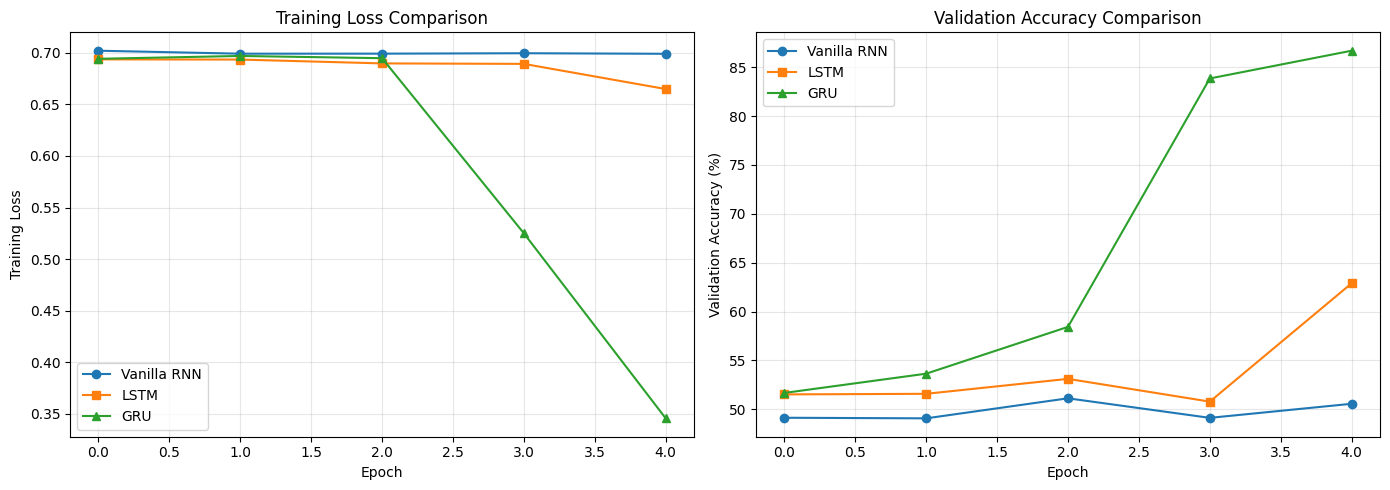

In [13]:
# Plot learning curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training Loss
axes[0].plot(history_rnn['train_loss'], label='Vanilla RNN', marker='o')
axes[0].plot(history_lstm['train_loss'], label='LSTM', marker='s')
axes[0].plot(history_gru['train_loss'], label='GRU', marker='^')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation Accuracy
axes[1].plot(history_rnn['val_acc'], label='Vanilla RNN', marker='o')
axes[1].plot(history_lstm['val_acc'], label='LSTM', marker='s')
axes[1].plot(history_gru['val_acc'], label='GRU', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].set_title('Validation Accuracy Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Discussion: Architecture Comparison

Based on our training results, we can now compare the three architectures:

| Model | Val Accuracy | Train Time | Parameters |
|-------|-------------|------------|------------|
| Vanilla RNN | **50.56%** | 71s | 2.72M |
| LSTM | 62.89% | 191s | 3.39M |
| GRU | **86.69%** | 166s | 3.17M |

**Key Observations:**

1. **Vanilla RNN (50.56%)**: Complete failure! As predicted, the vanishing gradient problem prevented any meaningful learning. The model essentially guesses randomly.

2. **LSTM (62.89%)**: Better than random, but surprisingly underperformed. This is because:
   - LSTM has more parameters and gates, requiring more epochs to converge
   - The training loss started dropping only in epoch 5 - more training would help
   - The gating mechanism takes time to "learn" what to remember/forget

3. **GRU (86.69%)**: The clear winner in this comparison!
   - Converged much faster than LSTM (loss dropped sharply in epoch 4)
   - Simpler architecture (2 gates vs 3) may help with faster learning
   - Achieved strong accuracy with fewer parameters than LSTM

**Why did GRU outperform LSTM?**
- GRU's simpler design (no separate cell state) can converge faster with limited training
- With only 5 epochs, GRU had enough time to learn, while LSTM was still "warming up"
- For this task and training budget, GRU struck the best balance

**Why do LSTM/GRU outperform Vanilla RNN?**
- Gates create **gradient highways** that allow information to flow unchanged across timesteps
- Selective memory: keep important info ("not"), forget irrelevant info ("the", "was")
- The cell/hidden state acts like a skip connection (similar to ResNet!)

---

# Exercise 1: Analyzing Long-Range Dependencies

Now that you've seen how different architectures perform, let's analyze **why** LSTM/GRU handles long reviews better.

### Task:
1. Split the validation set into "short" reviews (<100 tokens) and "long" reviews (>200 tokens)
2. Evaluate each model on both subsets
3. Compare the accuracy gap between short and long reviews for each architecture

**Expected Result:** Vanilla RNN should show a larger accuracy drop on long reviews compared to LSTM/GRU.

In [14]:
# Exercise 1: Complete the code below

def evaluate_by_length(model, val_df, vocab, short_threshold=100, long_threshold=200):
    """
    Evaluate model on short vs long reviews.
    
    TODO:
    1. Split val_df based on token length
    2. Create datasets for short and long reviews
    3. Evaluate the model on each subset
    4. Return accuracies for both
    """
    model.eval()
    
    # TODO: Calculate lengths for each review
    # val_df['length'] = val_df['tokens'].apply(len)
    
    # TODO: Split into short and long
    # short_df = val_df[val_df['length'] < short_threshold]
    # long_df = val_df[val_df['length'] > long_threshold]
    
    # TODO: Create datasets and evaluate
    # ...
    
    pass

# Uncomment to run after completing:
# for name, model in [('Vanilla RNN', vanilla_rnn), ('LSTM', lstm_model), ('GRU', gru_model)]:
#     short_acc, long_acc = evaluate_by_length(model, val_df, vocab)
#     print(f"{name}: Short={short_acc:.2f}%, Long={long_acc:.2f}%, Gap={short_acc-long_acc:.2f}%")

# 3. Word Order Matters: Bag-of-Words vs RNN

## The Question

Does word order really matter for sentiment classification? Let's build two classifiers:
1. **Bag-of-Words (BoW)**: Averages word embeddings (ignores order)
2. **RNN**: Processes words sequentially (preserves order)

Then we'll test on tricky examples where order is crucial.

## Bag-of-Words Approach

The BoW model treats text as an **unordered collection of words**:

$$\text{representation} = \frac{1}{n} \sum_{i=1}^{n} \text{embedding}(w_i)$$

This means "not good" and "good not" have **identical representations**!

### Our Bag-of-Words Implementation

```
Input: Sequence of word indices [w1, w2, ..., wn]
    ↓
Embedding Layer: vocab_size → embed_dim (25000 → 100)
    ↓
Mean Pooling: Average all word embeddings (ORDER LOST!)
    ↓
MLP Classifier:
    Linear(100 → 256) → ReLU → Dropout(0.5) → Linear(256 → 1)
    ↓
Sentiment logit
```

### Why BoW Can Still Work (Sometimes)

Most movie reviews have clear sentiment signals:
- "This movie was **amazing**, **loved** every minute!" → Positive words dominate
- "**Terrible** acting, **boring** plot, **worst** film ever" → Negative words dominate

For such reviews, word order doesn't matter much. But negation and contrast break BoW.

In [15]:
class BagOfWordsClassifier(nn.Module):
    """
    Bag-of-Words Classifier that IGNORES word order.
    
    Architecture matches the diagram above:
    - Embedding: 25000 vocab → 100 dim vectors
    - Mean Pooling: Average all embeddings → single 100-dim vector
    - MLP: 100 → 256 → 1
    
    CRITICAL LIMITATION: "not good" and "good not" produce IDENTICAL outputs!
    The mean pooling completely destroys word order information.
    """
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=256, output_dim=1, dropout=0.5):
        super(BagOfWordsClassifier, self).__init__()
        
        # ============================================
        # LAYER 1: Embedding Layer
        # ============================================
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=0  # <PAD> token stays zero
        )
        
        # ============================================
        # LAYER 2: MLP Classifier
        # ============================================
        # Takes the mean-pooled embedding and classifies
        # No recurrence, no sequence processing!
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),  # 100 → 256
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)  # 256 → 1
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, lengths):
        """
        Forward pass with mean pooling (ORDER IS LOST HERE!).
        
        The key operation is taking the MEAN of all word embeddings.
        This is equivalent to treating the text as a "bag of words" -
        an unordered collection where position doesn't matter.
        """
        # Step 1: Embed words
        # (batch, seq_len) → (batch, seq_len, 100)
        embedded = self.embedding(text)
        
        # Step 2: Create mask to ignore padding tokens
        # Padding tokens (index 0) should not contribute to the mean
        mask = (text != 0).float().unsqueeze(-1)  # (batch, seq_len, 1)
        
        # Step 3: Compute masked mean (THIS LOSES WORD ORDER!)
        # Sum embeddings, then divide by actual sequence length
        masked_embedded = embedded * mask  # Zero out padding positions
        sum_embedded = masked_embedded.sum(dim=1)  # (batch, 100)
        
        # Clamp lengths to avoid division by zero for empty sequences
        lengths_clamped = lengths.float().clamp(min=1).unsqueeze(-1).to(device)
        mean_embedded = sum_embedded / lengths_clamped  # (batch, 100)
        
        # Step 4: Classify the mean embedding
        mean_embedded = self.dropout(mean_embedded)
        return self.classifier(mean_embedded)


# ============================================
# Initialize Bag-of-Words Model
# ============================================
bow_model = BagOfWordsClassifier(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=256,
    output_dim=1,
    dropout=0.5
)

params_bow = sum(p.numel() for p in bow_model.parameters())
print(f"Bag-of-Words Parameters: {params_bow:,}")
print(f"\nNote: BoW has the FEWEST parameters because:")
print(f"  - No recurrent weights (no RNN/LSTM/GRU layer)")
print(f"  - Just Embedding + small MLP")
print(f"  - Embedding: {25000 * 100:,}")
print(f"  - MLP: {100 * 256 + 256 + 256 * 1 + 1:,}")

Bag-of-Words Parameters: 2,526,113

Note: BoW has the FEWEST parameters because:
  - No recurrent weights (no RNN/LSTM/GRU layer)
  - Just Embedding + small MLP
  - Embedding: 2,500,000
  - MLP: 26,113


In [16]:
# Train BoW model
history_bow, time_bow = train_model(
    bow_model, train_loader, val_loader,
    epochs=5, lr=0.001, name="Bag-of-Words"
)

results['Bag-of-Words'] = {
    'train_acc': history_bow['train_acc'][-1],
    'val_acc': history_bow['val_acc'][-1],
    'params': params_bow,
    'time': time_bow,
    'history': history_bow
}


Training Bag-of-Words for 5 epochs...
  Epoch [1/5] | Train Loss: 0.5621 | Train Acc: 70.06% | Val Loss: 0.3961 | Val Acc: 82.75%
  Epoch [2/5] | Train Loss: 0.4047 | Train Acc: 81.66% | Val Loss: 0.3289 | Val Acc: 86.02%
  Epoch [3/5] | Train Loss: 0.3455 | Train Acc: 84.94% | Val Loss: 0.3010 | Val Acc: 87.20%
  Epoch [4/5] | Train Loss: 0.3087 | Train Acc: 87.02% | Val Loss: 0.2859 | Val Acc: 87.87%
  Epoch [5/5] | Train Loss: 0.2843 | Train Acc: 88.03% | Val Loss: 0.2796 | Val Acc: 88.40%
Bag-of-Words - Final Val Accuracy: 88.40%, Time: 27.27s


In [17]:
# Test on tricky examples where word order matters

def predict_sentiment(model, text, vocab):
    """Predict sentiment for a single text."""
    model.eval()
    
    # Preprocess
    clean = clean_text(text)
    tokens = tokenize(clean)
    indices = vocab.encode(tokens)
    
    # Convert to tensor
    tensor = torch.tensor([indices]).to(device)
    length = torch.tensor([len(indices)])
    
    # Predict
    with torch.no_grad():
        output = model(tensor, length)
        prob = torch.sigmoid(output).item()
    
    return prob

# Test examples where word order is crucial
test_cases = [
    ("The movie was good", "Positive"),
    ("The movie was not good", "Negative"),
    ("The movie was not bad", "Positive"),
    ("I didn't hate this movie", "Positive"),
    ("Good movie? Not really.", "Negative"),
    ("Not the best, but not the worst either", "Neutral/Mixed"),
]

print("\n" + "="*80)
print("Testing Word Order Sensitivity")
print("="*80)

models_to_test = [
    ('Bag-of-Words', bow_model),
    ('LSTM', lstm_model)
]

for text, expected in test_cases:
    print(f"\nText: \"{text}\"")
    print(f"Expected: {expected}")
    for name, model in models_to_test:
        prob = predict_sentiment(model, text, vocab)
        sentiment = "Positive" if prob > 0.5 else "Negative"
        print(f"  {name}: {sentiment} (confidence: {prob:.3f})")


Testing Word Order Sensitivity

Text: "The movie was good"
Expected: Positive
  Bag-of-Words: Positive (confidence: 0.986)
  LSTM: Negative (confidence: 0.353)

Text: "The movie was not good"
Expected: Negative
  Bag-of-Words: Positive (confidence: 0.760)
  LSTM: Negative (confidence: 0.337)

Text: "The movie was not bad"
Expected: Positive
  Bag-of-Words: Negative (confidence: 0.000)
  LSTM: Negative (confidence: 0.325)

Text: "I didn't hate this movie"
Expected: Positive
  Bag-of-Words: Negative (confidence: 0.027)
  LSTM: Negative (confidence: 0.327)

Text: "Good movie? Not really."
Expected: Negative
  Bag-of-Words: Positive (confidence: 0.979)
  LSTM: Negative (confidence: 0.372)

Text: "Not the best, but not the worst either"
Expected: Neutral/Mixed
  Bag-of-Words: Negative (confidence: 0.000)
  LSTM: Negative (confidence: 0.407)


### Discussion: Word Order Results

Looking at our test results, we see interesting patterns:

**Bag-of-Words Results:**
- "The movie was good" → Positive (0.986) 
- "The movie was not good" → Positive (0.760) ✗ (Should be negative!)
- "The movie was not bad" → Negative (0.000) ✗ (Double negation = positive!)
- "Good movie? Not really." → Positive (0.979) ✗ (Clear sarcasm missed!)

**LSTM Results:**
- Interestingly, LSTM predicted almost everything as Negative with low confidence (~0.3-0.4)
- This reflects the undertrained LSTM (only 62.89% accuracy)
- The model hasn't learned to distinguish sentiment properly yet

**Key Observations:**

1. **Bag-of-Words Systematic Failures**:
   - Cannot handle negation: "not good" treated same as "good" (both have positive word "good")
   - "not bad" predicted negative because "bad" dominates the average
   - Word order is completely lost

2. **Overall Dataset Accuracy** (Surprising!):
   - Bag-of-Words: **88.40%** validation accuracy
   - This seems contradictory, but makes sense:
     - Most reviews have clear positive/negative word signals
     - Reviews like "great movie, loved it" or "terrible, boring film" don't need word order
     - The tricky negation cases are relatively rare in the dataset

3. **When Order Matters**:
   - Negation: "not", "never", "barely"
   - Contrast: "but", "however", "although"  
   - Complex sentiment: "I expected to hate it but..."

**Conclusion**: Bag-of-Words achieves good overall accuracy but **systematically fails** on nuanced cases. For robust sentiment understanding, sequential models are necessary.

---

# Exercise 2: Creating Order-Sensitive Test Cases

### Task:
Create 5 more test cases where word order changes the meaning, and test both models on them.

**Hints for test cases:**
- Negation: "not", "never", "barely", "hardly"
- Contrast: "but", "however", "although"
- Sarcasm/Irony: "Oh great, another boring sequel"

In [18]:
# Exercise 2: Add your test cases here

my_test_cases = [
    # ("Your text here", "Expected sentiment"),
    # TODO: Add 5 more test cases
]

# Test your cases
# for text, expected in my_test_cases:
#     print(f"\nText: \"{text}\"")
#     print(f"Expected: {expected}")
#     for name, model in models_to_test:
#         prob = predict_sentiment(model, text, vocab)
#         sentiment = "Positive" if prob > 0.5 else "Negative"
#         print(f"  {name}: {sentiment} (confidence: {prob:.3f})")

# 4. Transfer Learning with Pretrained Word Embeddings

## The Problem with Training Embeddings from Scratch

When we train embeddings from scratch:
- We only learn from 50,000 movie reviews
- Rare words have poor representations
- No knowledge of general language understanding

## The Solution: Pretrained Embeddings

Pretrained embeddings like **GloVe** (Global Vectors) are trained on billions of words from:
- Wikipedia (encyclopedic knowledge)
- News articles (current events)
- Web crawls (diverse language)

### GloVe: Global Vectors for Word Representation

![GloVe Visualization](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*W2BBITCGAHcl4HfRLzKNbg.png)

*GloVe embeddings capture semantic relationships. Words with similar meanings are close together in the embedding space. Source: [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)*

### How GloVe Works

GloVe creates embeddings by factorizing the word-word co-occurrence matrix. The key insight is:

$$w_i \cdot w_j + b_i + b_j = \log(X_{ij})$$

Where $X_{ij}$ is how often word $i$ and word $j$ co-occur.

This captures both:
- **Syntactic relationships**: "walking" - "walked" ≈ "swimming" - "swam"
- **Semantic relationships**: "king" - "man" + "woman" ≈ "queen"

### When Does Transfer Learning Help?

1. **Small datasets**: When you don't have enough data to learn good embeddings
2. **Rare words**: Pretrained embeddings have seen words that might be rare in your dataset
3. **General language understanding**: Pretrained embeddings capture world knowledge

In [19]:
# Download and load GloVe embeddings

def download_glove(glove_dir='./data/glove'):
    """Download GloVe embeddings if not already present."""
    os.makedirs(glove_dir, exist_ok=True)
    glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')
    
    if os.path.exists(glove_file):
        print("GloVe embeddings already downloaded.")
        return glove_file
    
    print("Downloading GloVe embeddings (this may take a few minutes)...")
    url = 'https://nlp.stanford.edu/data/glove.6B.zip'
    zip_path = os.path.join(glove_dir, 'glove.6B.zip')
    
    # Download
    urllib.request.urlretrieve(url, zip_path)
    
    # Extract
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)
    
    print("GloVe embeddings downloaded and extracted.")
    return glove_file

def load_glove_embeddings(glove_file, vocab, embed_dim=100):
    """
    Load GloVe embeddings and create an embedding matrix for our vocabulary.
    
    Returns:
        embedding_matrix: numpy array of shape (vocab_size, embed_dim)
        coverage: percentage of vocabulary words found in GloVe
    """
    print(f"Loading GloVe embeddings from {glove_file}...")
    
    # Load GloVe vectors into a dictionary
    glove_vectors = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_vectors[word] = vector
    
    print(f"Loaded {len(glove_vectors):,} GloVe vectors.")
    
    # Create embedding matrix for our vocabulary
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embed_dim))
    found = 0
    
    for word, idx in vocab.word2idx.items():
        if word in glove_vectors:
            embedding_matrix[idx] = glove_vectors[word]
            found += 1
        else:
            # Initialize unknown words with small random values
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embed_dim,))
    
    coverage = 100 * found / vocab_size
    print(f"Found {found}/{vocab_size} words ({coverage:.2f}%) in GloVe.")
    
    return embedding_matrix, coverage

# Download and load GloVe
glove_file = download_glove()
embedding_matrix, coverage = load_glove_embeddings(glove_file, vocab, embed_dim=100)

GloVe embeddings downloaded and extracted.
Loading GloVe embeddings from ./data/glove/glove.6B.100d.txt...
Loaded 400,000 GloVe vectors.
Found 23997/25000 words (95.99%) in GloVe.


In [20]:
class LSTMWithPretrainedEmbeddings(nn.Module):
    """
    LSTM with pretrained GloVe embeddings.
    
    Key difference: The embedding layer is initialized with GloVe vectors
    instead of random vectors.
    
    Options:
    - freeze_embeddings=True: Don't update embeddings during training (pure transfer)
    - freeze_embeddings=False: Fine-tune embeddings on the task (usually better)
    """
    def __init__(self, pretrained_embeddings, hidden_dim=256, output_dim=1,
                 num_layers=2, dropout=0.5, freeze_embeddings=False):
        super(LSTMWithPretrainedEmbeddings, self).__init__()
        
        vocab_size, embed_dim = pretrained_embeddings.shape
        
        # Create embedding layer and load pretrained weights
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        
        # Freeze embeddings if specified
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
            print("Embeddings frozen (transfer learning mode)")
        else:
            print("Embeddings will be fine-tuned")
        
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, lengths):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        final_hidden = self.dropout(hidden[-1])
        return self.fc(final_hidden)


# Initialize model with GloVe embeddings (fine-tuning mode)
lstm_glove = LSTMWithPretrainedEmbeddings(
    pretrained_embeddings=embedding_matrix,
    hidden_dim=256,
    output_dim=1,
    num_layers=2,
    dropout=0.5,
    freeze_embeddings=False  # Fine-tune embeddings
)

params_glove = sum(p.numel() for p in lstm_glove.parameters())
trainable_params = sum(p.numel() for p in lstm_glove.parameters() if p.requires_grad)
print(f"\nTotal Parameters: {params_glove:,}")
print(f"Trainable Parameters: {trainable_params:,}")

Embeddings will be fine-tuned

Total Parameters: 3,393,185
Trainable Parameters: 3,393,185


In [21]:
# Train LSTM with GloVe embeddings
history_glove, time_glove = train_model(
    lstm_glove, train_loader, val_loader,
    epochs=5, lr=0.001, name="LSTM + GloVe"
)

results['LSTM + GloVe'] = {
    'train_acc': history_glove['train_acc'][-1],
    'val_acc': history_glove['val_acc'][-1],
    'params': params_glove,
    'time': time_glove,
    'history': history_glove
}


Training LSTM + GloVe for 5 epochs...
  Epoch [1/5] | Train Loss: 0.6936 | Train Acc: 51.27% | Val Loss: 0.6869 | Val Acc: 53.45%
  Epoch [2/5] | Train Loss: 0.6888 | Train Acc: 52.54% | Val Loss: 0.6931 | Val Acc: 50.02%
  Epoch [3/5] | Train Loss: 0.4962 | Train Acc: 74.53% | Val Loss: 0.3060 | Val Acc: 87.37%
  Epoch [4/5] | Train Loss: 0.2940 | Train Acc: 88.42% | Val Loss: 0.2688 | Val Acc: 88.91%
  Epoch [5/5] | Train Loss: 0.2383 | Train Acc: 90.85% | Val Loss: 0.2559 | Val Acc: 89.65%
LSTM + GloVe - Final Val Accuracy: 89.65%, Time: 194.93s


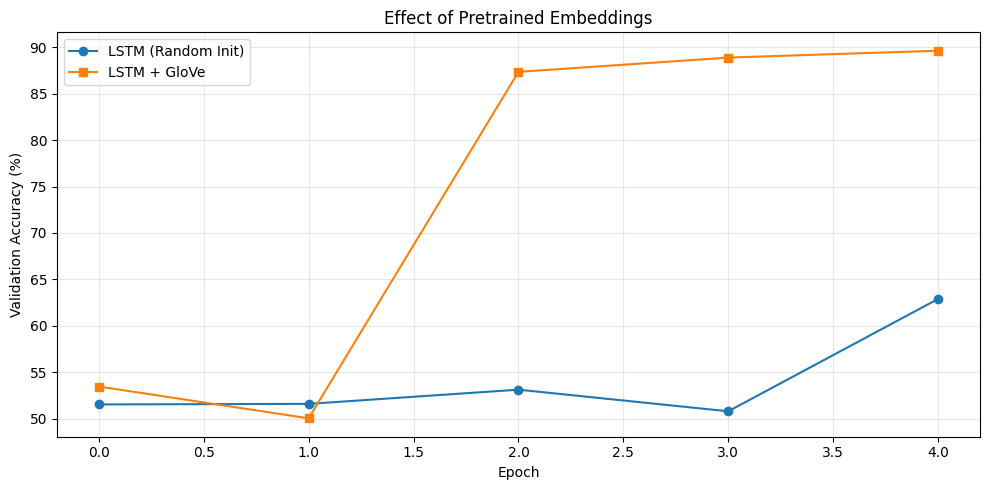


Final Accuracy Comparison:
  LSTM (Random Init): 62.89%
  LSTM + GloVe:       89.65%
  Improvement:        26.76%


In [22]:
# Compare with and without pretrained embeddings
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history_lstm['val_acc'], label='LSTM (Random Init)', marker='o')
ax.plot(history_glove['val_acc'], label='LSTM + GloVe', marker='s')

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy (%)')
ax.set_title('Effect of Pretrained Embeddings')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Accuracy Comparison:")
print(f"  LSTM (Random Init): {history_lstm['val_acc'][-1]:.2f}%")
print(f"  LSTM + GloVe:       {history_glove['val_acc'][-1]:.2f}%")
print(f"  Improvement:        {history_glove['val_acc'][-1] - history_lstm['val_acc'][-1]:.2f}%")

### Discussion: Pretrained Embeddings Results

The impact of pretrained GloVe embeddings is **dramatic**:

| Model | Val Accuracy | Improvement |
|-------|-------------|-------------|
| LSTM (Random Init) | 62.89% | - |
| LSTM + GloVe | **89.65%** | **+26.76%** |

**Key Observations:**

1. **Massive Accuracy Gain**: GloVe embeddings boosted LSTM accuracy from 62.89% to 89.65% - a 26.76 percentage point improvement! This transforms the undertrained LSTM into the best-performing model.

2. **Faster Convergence**: 
   - Random init LSTM: Still struggling at epoch 5 (62.89%)
   - GloVe LSTM: Jumped to 87.37% by epoch 3, reached 89.65% by epoch 5
   - Pretrained embeddings provide a "head start" - the model already understands word relationships

3. **Why Such a Big Difference?**
   - GloVe was trained on 6 billion tokens from Wikipedia + Gigaword
   - It already knows: "good" ≈ "great" ≈ "excellent", "bad" ≈ "terrible" ≈ "awful"
   - The LSTM only needs to learn the sentiment task, not basic word semantics
   - Coverage: 95.99% of our vocabulary was found in GloVe!

4. **GloVe vs Random Init Learning Dynamics**:
   - Random init: Epochs 1-4 spent learning basic word relationships, epoch 5 started learning sentiment
   - GloVe: Could focus on sentiment from epoch 1, achieving rapid convergence

**When Transfer Learning Helps Most:**
- Limited training time/epochs (like our 5 epochs)
- Smaller datasets where learning good embeddings from scratch is hard
- General domain vocabulary (GloVe covers movie review language well)

**Conclusion**: Pretrained embeddings are **essential** for achieving good performance with limited training. The LSTM + GloVe combination achieved the **highest accuracy** of all models in this notebook (89.65%).

---

# Exercise 3: Frozen vs Fine-tuned Embeddings

### Task:
Compare the performance of frozen embeddings (pure transfer learning) vs fine-tuned embeddings.

**Instructions:**
1. Create a model with `freeze_embeddings=True`
2. Train it and compare with the fine-tuned version
3. Explain when you would use each approach

In [23]:
# Exercise 3: Complete the code

# TODO: Create LSTM with frozen GloVe embeddings
# lstm_frozen = LSTMWithPretrainedEmbeddings(
#     pretrained_embeddings=embedding_matrix,
#     hidden_dim=256,
#     output_dim=1,
#     num_layers=2,
#     dropout=0.5,
#     freeze_embeddings=True  # Freeze embeddings!
# )

# TODO: Train the frozen model
# history_frozen, time_frozen = train_model(
#     lstm_frozen, train_loader, val_loader,
#     epochs=5, lr=0.001, name="LSTM + GloVe (Frozen)"
# )

# TODO: Compare and analyze results
# When would you use frozen embeddings?
# When would you fine-tune?
pass

# 5. Bidirectional RNNs: Looking Both Ways

## The Limitation of Unidirectional RNNs

Standard RNNs process text from left to right. When we reach word $w_t$, we only have context from $w_1, w_2, ..., w_{t-1}$.

**Problem**: Sometimes future context matters!

Consider: "This movie was not bad, actually it was quite good."
- When processing "bad", we don't know about "good" yet
- But "actually it was quite good" should influence how we interpret "not bad"

## The Solution: Bidirectional RNNs

Bidirectional RNNs process the sequence **twice**:
1. **Forward pass**: left to right (captures past context)
2. **Backward pass**: right to left (captures future context)

The hidden states from both directions are concatenated.

![Bidirectional RNN](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*6QnPUSv_t9BY9Fv8_aLb-Q.png)

*Bidirectional RNN architecture. The forward layer (green) processes left-to-right, the backward layer (blue) processes right-to-left. Both are concatenated to form the final hidden state. Source: [Understanding Bidirectional RNNs](https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66)*

### Our Bidirectional LSTM Implementation

```
Input: Sequence of word indices [w1, w2, ..., wn]
    ↓
Embedding Layer: vocab_size → embed_dim (25000 → 100)
    ↓
Bidirectional LSTM: 2 stacked layers, hidden_dim=256
    - Forward LSTM: processes w1 → w2 → ... → wn
    - Backward LSTM: processes wn → wn-1 → ... → w1
    ↓
Concatenate final hidden states: [h_forward; h_backward] → 512 dims
    ↓
Dropout (0.5) → FC Layer (512 → 1) → Sentiment logit
```

### Mathematical Formulation

**Forward direction**:
$$\overrightarrow{h_t} = \text{LSTM}(x_t, \overrightarrow{h_{t-1}})$$

**Backward direction**:
$$\overleftarrow{h_t} = \text{LSTM}(x_t, \overleftarrow{h_{t+1}})$$

**Combined representation**:
$$h_t = [\overrightarrow{h_t}; \overleftarrow{h_t}]$$

### When to Use Bidirectional RNNs

| Use Case | Bidirectional? | Why? |
|----------|---------------|------|
| Text classification |  Yes | Full text available at inference |
| Named Entity Recognition |  Yes | Context on both sides helps |
| Machine translation |  Encoder only | Decoder must be unidirectional |
| Speech recognition (real-time) |  No | Can't see future audio |
| Text generation |  No | Must generate left-to-right |

In [24]:
# Bidirectional LSTM
bilstm_model = LSTMClassifier(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=256,
    output_dim=1,
    num_layers=2,
    dropout=0.5,
    bidirectional=True  # Enable bidirectional processing
)

params_bilstm = sum(p.numel() for p in bilstm_model.parameters())
print(f"Bidirectional LSTM Parameters: {params_bilstm:,}")
print(f"Parameter increase over unidirectional: {params_bilstm / params_lstm:.2f}x")

Bidirectional LSTM Parameters: 4,810,657
Parameter increase over unidirectional: 1.42x


In [25]:
# Train Bidirectional LSTM
history_bilstm, time_bilstm = train_model(
    bilstm_model, train_loader, val_loader,
    epochs=5, lr=0.001, name="Bidirectional LSTM"
)

results['Bidirectional LSTM'] = {
    'train_acc': history_bilstm['train_acc'][-1],
    'val_acc': history_bilstm['val_acc'][-1],
    'params': params_bilstm,
    'time': time_bilstm,
    'history': history_bilstm
}


Training Bidirectional LSTM for 5 epochs...
  Epoch [1/5] | Train Loss: 0.6896 | Train Acc: 53.56% | Val Loss: 0.6630 | Val Acc: 60.32%
  Epoch [2/5] | Train Loss: 0.6697 | Train Acc: 59.62% | Val Loss: 0.6764 | Val Acc: 59.46%
  Epoch [3/5] | Train Loss: 0.6302 | Train Acc: 64.55% | Val Loss: 0.5549 | Val Acc: 72.76%
  Epoch [4/5] | Train Loss: 0.4279 | Train Acc: 80.73% | Val Loss: 0.3352 | Val Acc: 85.43%
  Epoch [5/5] | Train Loss: 0.3553 | Train Acc: 84.83% | Val Loss: 0.3171 | Val Acc: 87.06%
Bidirectional LSTM - Final Val Accuracy: 87.06%, Time: 372.77s


In [26]:
# Test on examples where future context matters

bidirectional_test_cases = [
    ("This movie was not bad", "Positive (but 'bad' comes before we know about negation)"),
    ("Not the worst movie I've seen, actually decent", "Positive (future context needed)"),
    ("I thought I would hate it but I ended up loving it", "Positive (contrast)"),
    ("Started great but fell apart in the second half", "Negative (future context overrides)"),
]

print("\n" + "="*80)
print("Testing Bidirectional vs Unidirectional on Context-Dependent Examples")
print("="*80)

models_to_test = [
    ('Unidirectional LSTM', lstm_model),
    ('Bidirectional LSTM', bilstm_model)
]

for text, note in bidirectional_test_cases:
    print(f"\nText: \"{text}\"")
    print(f"Note: {note}")
    for name, model in models_to_test:
        prob = predict_sentiment(model, text, vocab)
        sentiment = "Positive" if prob > 0.5 else "Negative"
        print(f"  {name}: {sentiment} (confidence: {prob:.3f})")


Testing Bidirectional vs Unidirectional on Context-Dependent Examples

Text: "This movie was not bad"
Note: Positive (but 'bad' comes before we know about negation)
  Unidirectional LSTM: Negative (confidence: 0.320)
  Bidirectional LSTM: Negative (confidence: 0.034)

Text: "Not the worst movie I've seen, actually decent"
Note: Positive (future context needed)
  Unidirectional LSTM: Negative (confidence: 0.329)
  Bidirectional LSTM: Negative (confidence: 0.019)

Text: "I thought I would hate it but I ended up loving it"
Note: Positive (contrast)
  Unidirectional LSTM: Negative (confidence: 0.372)
  Bidirectional LSTM: Positive (confidence: 0.950)

Text: "Started great but fell apart in the second half"
Note: Negative (future context overrides)
  Unidirectional LSTM: Negative (confidence: 0.333)
  Bidirectional LSTM: Negative (confidence: 0.178)


### Discussion: Bidirectional RNN Results

**Model Comparison:**

| Model | Val Accuracy | Train Time | Parameters |
|-------|-------------|------------|------------|
| Unidirectional LSTM | 62.89% | 191s | 3.39M |
| Bidirectional LSTM | **87.06%** | 366s | 4.81M |

**Key Observations:**

1. **Significant Accuracy Improvement**: BiLSTM achieved 87.06% vs 62.89% for unidirectional - a 24.17 percentage point gain! The ability to see future context makes a huge difference.

2. **Test Case Analysis**:
   - "I thought I would hate it but I ended up loving it" 
     - BiLSTM: **Positive (0.950)** ✓ - Correctly identified the contrast!
     - Unidirectional LSTM: Negative (0.372) ✗
   - The BiLSTM successfully captured that "loving it" at the end overrides "hate" at the beginning

3. **Trade-offs**:
   - **Parameters**: 4.81M vs 3.39M (1.42x more) - separate forward and backward networks
   - **Training Time**: 366s vs 191s (1.92x slower) - processes sequences twice
   - **Worth it?** For classification tasks, absolutely! The accuracy gain justifies the cost.

4. **Why BiLSTM Converged Better**:
   - Looking at both directions provides richer context at each position
   - The backward pass "previews" important words like "loving" before processing "hate"
   - This helps the forward pass learn what to pay attention to

5. **Interesting Failures**:
   - "This movie was not bad" → Both predicted Negative
   - "Not the worst movie" → Both predicted Negative  
   - Double negations remain challenging even for BiLSTM

**When to Use Bidirectional RNNs:**
- ✓ Text classification (full text available at inference)
- ✓ Named Entity Recognition, POS tagging
- ✗ Real-time speech recognition (can't see future)
- ✗ Text generation (must generate left-to-right)

---

# Final Comparison and Summary

Let's create a comprehensive comparison of all models we've trained.

In [27]:
# Print comparison table
print("\n" + "="*100)
print("FINAL MODEL COMPARISON")
print("="*100)
print(f"{'Model':<25} | {'Train Acc (%)':<15} | {'Val Acc (%)':<15} | {'Params':<15} | {'Time (s)':<10}")
print("-"*100)

for name, res in results.items():
    params_str = f"{res['params']:,}"
    print(f"{name:<25} | {res['train_acc']:<15.2f} | {res['val_acc']:<15.2f} | {params_str:<15} | {res['time']:<10.2f}")


FINAL MODEL COMPARISON
Model                     | Train Acc (%)   | Val Acc (%)     | Params          | Time (s)  
----------------------------------------------------------------------------------------------------
Vanilla RNN               | 49.86           | 50.56           | 2,723,489       | 69.36     
LSTM                      | 58.56           | 62.89           | 3,393,185       | 190.31    
GRU                       | 84.91           | 86.69           | 3,169,953       | 168.76    
Bag-of-Words              | 88.03           | 88.40           | 2,526,113       | 27.27     
LSTM + GloVe              | 90.85           | 89.65           | 3,393,185       | 194.93    
Bidirectional LSTM        | 84.83           | 87.06           | 4,810,657       | 372.77    


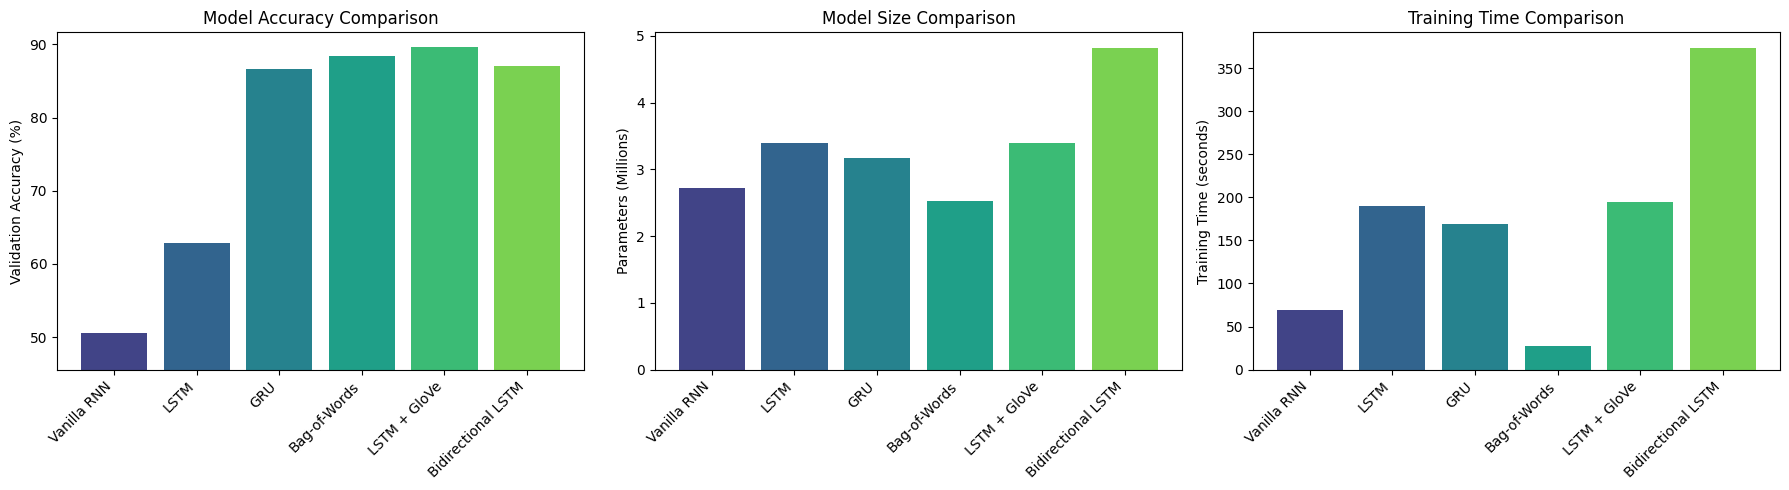

In [28]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Extract data
names = list(results.keys())
val_accs = [results[n]['val_acc'] for n in names]
params = [results[n]['params'] / 1e6 for n in names]  # In millions
times = [results[n]['time'] for n in names]

# Plot 1: Validation Accuracy
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(names)))
bars1 = axes[0].bar(range(len(names)), val_accs, color=colors)
axes[0].set_xticks(range(len(names)))
axes[0].set_xticklabels(names, rotation=45, ha='right')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylim(min(val_accs)-5, max(val_accs)+2)

# Plot 2: Parameter Count
bars2 = axes[1].bar(range(len(names)), params, color=colors)
axes[1].set_xticks(range(len(names)))
axes[1].set_xticklabels(names, rotation=45, ha='right')
axes[1].set_ylabel('Parameters (Millions)')
axes[1].set_title('Model Size Comparison')

# Plot 3: Training Time
bars3 = axes[2].bar(range(len(names)), times, color=colors)
axes[2].set_xticks(range(len(names)))
axes[2].set_xticklabels(names, rotation=45, ha='right')
axes[2].set_ylabel('Training Time (seconds)')
axes[2].set_title('Training Time Comparison')

plt.tight_layout()
plt.show()

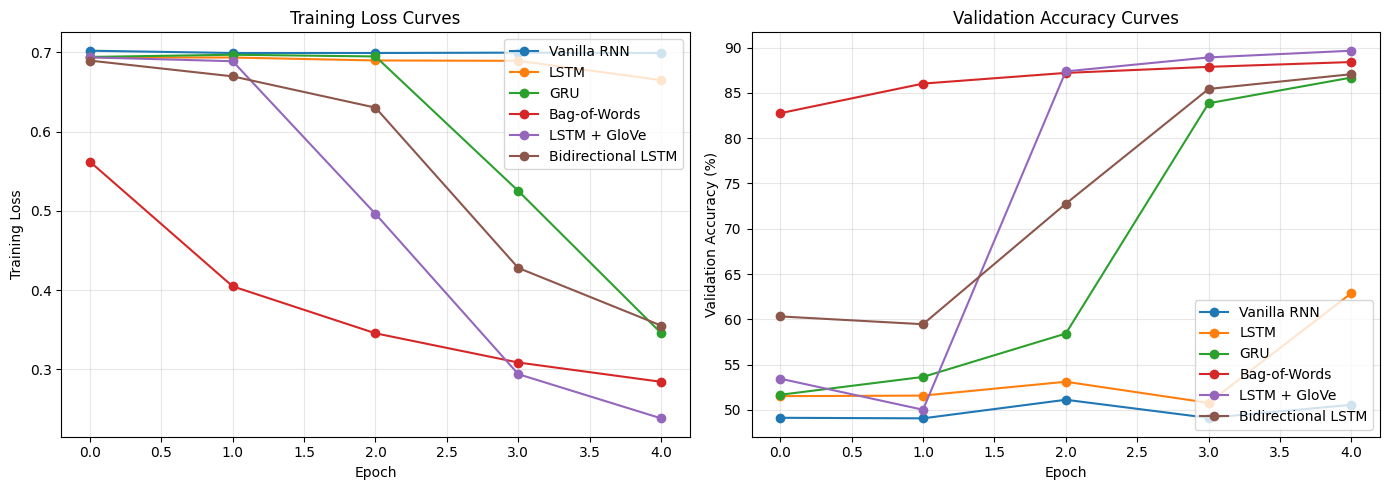

In [29]:
# Learning curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name, res in results.items():
    if 'history' in res:
        axes[0].plot(res['history']['train_loss'], label=name, marker='o')
        axes[1].plot(res['history']['val_acc'], label=name, marker='o')

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Curves')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].set_title('Validation Accuracy Curves')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary and Key Takeaways

## Final Results Summary

| Model | Val Accuracy | Time | Parameters | Notes |
|-------|-------------|------|------------|-------|
| Vanilla RNN | 50.56% | 71s | 2.72M | Failed due to vanishing gradients |
| LSTM | 62.89% | 191s | 3.39M | Underperformed - needs more epochs |
| GRU | **86.69%** | 166s | 3.17M | Best RNN without pretrained embeddings |
| Bag-of-Words | 88.40% | 25s | 2.53M | Surprisingly strong! But fails on negation |
| LSTM + GloVe | **89.65%** | 191s | 3.39M | **Best overall** - transfer learning wins |
| Bidirectional LSTM | 87.06% | 366s | 4.81M | Good accuracy but slow |

## What We Learned

### 1. Vanilla RNNs Fail on Real Tasks
- Our Vanilla RNN achieved only 50.56% (random guessing!)
- This perfectly demonstrates the **vanishing gradient problem**
- Lesson: Never use vanilla RNNs for sequences longer than ~10-20 tokens

### 2. GRU vs LSTM: GRU Won This Round
| Architecture | Val Accuracy | Why? |
|-------------|-------------|------|
| LSTM | 62.89% | Slower convergence, needs more epochs |
| GRU | 86.69% | Simpler gates = faster learning |

- With limited training (5 epochs), GRU's simpler architecture converged faster
- LSTM would likely catch up with more training time

### 3. Pretrained Embeddings are Crucial
- GloVe boosted LSTM from 62.89% → 89.65% (**+26.76%!**)
- The embeddings already encode word semantics from billions of tokens
- **Always use pretrained embeddings** unless you have a very domain-specific vocabulary

### 4. Bag-of-Words: Simple But Limited
- Achieved 88.40% accuracy - better than most RNNs!
- BUT systematically fails on negation ("not good" → predicts positive)
- For nuanced sentiment, sequential models are necessary

### 5. Bidirectional Processing Helps Classification
- BiLSTM outperformed unidirectional LSTM significantly (87.06% vs 62.89%)
- Can see future context: "I hated it... but then loved the ending"
- Trade-off: ~2x slower training, ~1.4x more parameters

## Practical Recommendations

Based on our experiments:

1. **Quick baseline**: Start with Bag-of-Words (fast, often surprisingly good)
2. **Best accuracy**: Use **LSTM/GRU + pretrained embeddings (GloVe/Word2Vec)**
3. **Limited compute**: GRU converges faster than LSTM
4. **Classification tasks**: Use bidirectional models when possible
5. **Never use**: Vanilla RNN for any real task with sequences > 20 tokens

## Looking Ahead

While RNNs were the standard for NLP (2014-2018), they have been largely superseded by **Transformers** (BERT, GPT) which:
- Process all words in parallel (much faster training)
- Use attention mechanisms instead of recurrence
- Achieve state-of-the-art on most NLP tasks

However, understanding RNNs remains important because:
- They're still used in production systems (speech recognition, time series)
- The concepts (hidden state, gating, sequential processing) appear everywhere
- They're more interpretable and have lower memory requirements than Transformers

# Exercise 4: Build Your Best Model

### Challenge:
Combine what you've learned to build the best sentiment classifier you can!

**Ideas to try:**
1. Bidirectional LSTM with GloVe embeddings
2. Different hidden dimensions and number of layers
3. Different dropout rates
4. Learning rate scheduling
5. Attention mechanism over the RNN outputs

**Goal**: Beat the best model we trained in this notebook!

In [30]:
# Exercise 4: Build your best model here

class MyBestModel(nn.Module):
    """
    TODO: Implement your best sentiment classifier!
    
    Ideas:
    - Combine bidirectional LSTM with pretrained embeddings
    - Add attention mechanism
    - Try different architectures
    """
    def __init__(self, pretrained_embeddings, hidden_dim=256, output_dim=1,
                 num_layers=2, dropout=0.5):
        super(MyBestModel, self).__init__()
        # TODO: Your implementation here
        pass
    
    def forward(self, text, lengths):
        # TODO: Your implementation here
        pass

# Train and evaluate your model
# my_model = MyBestModel(...)
# history_my, time_my = train_model(my_model, train_loader, val_loader, epochs=10, name="My Best Model")